In [43]:

#importing necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import xlrd
import pandas as pd
import datetime
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

In [44]:
data = pd.read_csv("UKdataFinal.csv")
data.drop('Unnamed: 0',axis=1,inplace=True) 
data.head(5)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [45]:
data = data.rename(columns={'Customer ID': 'CustomerID'})

In [46]:
data.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

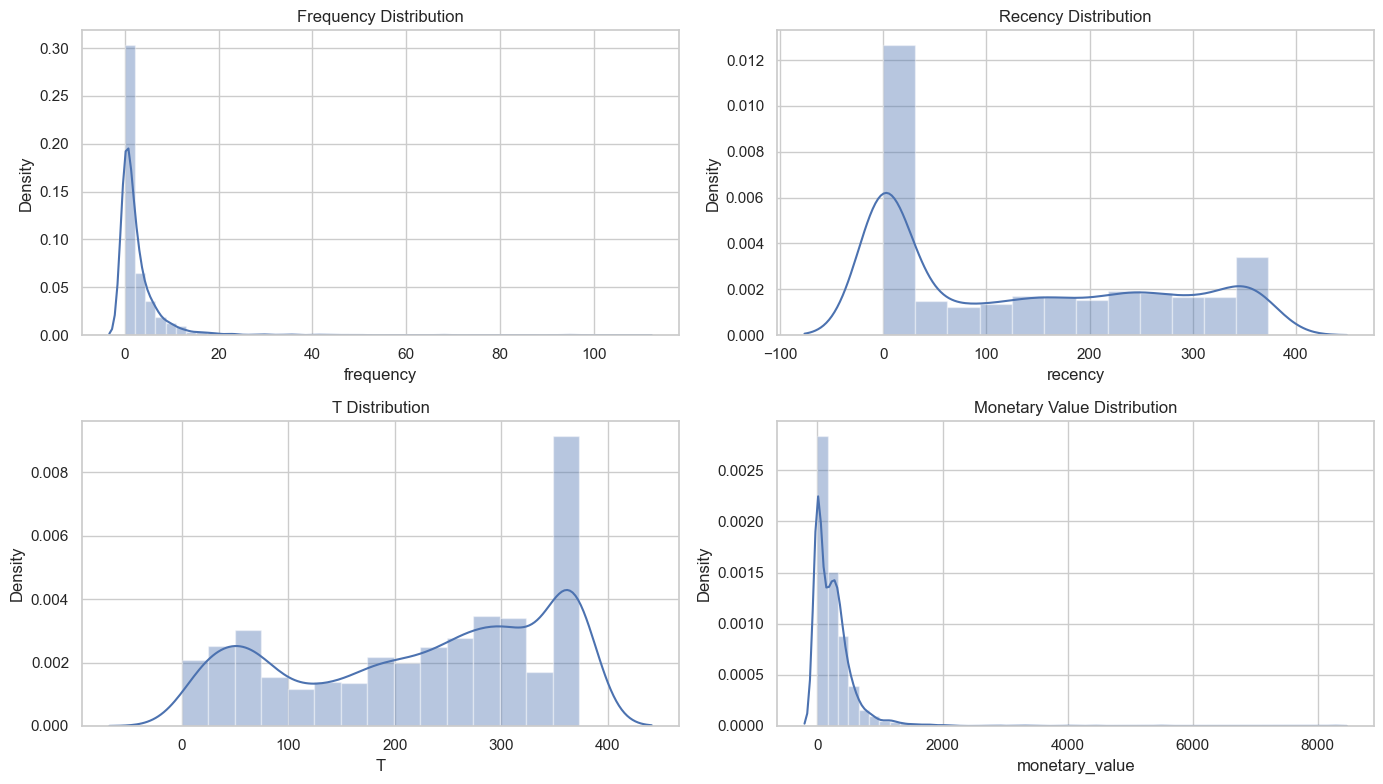

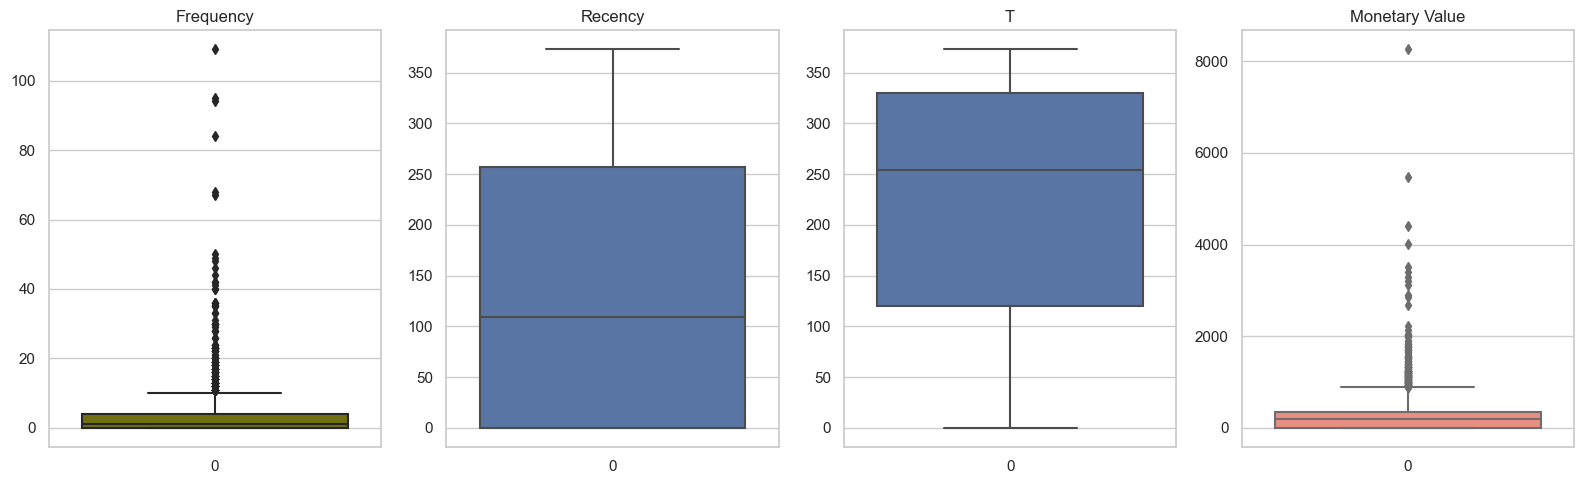

In [151]:

data = data[(data['Quantity']>0)]
data["Total Amount"] = data["Quantity"]*data["Price"]
#calculating the recency, frequency, T, monetary_value
summary = lifetimes.utils.summary_data_from_transaction_data(data, "CustomerID", "InvoiceDate", "Total Amount")
summary = summary.reset_index() #resetting the index
summary 

#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(summary["monetary_value"], color = "salmon")
plt.title("Monetary Value")
plt.tight_layout()

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

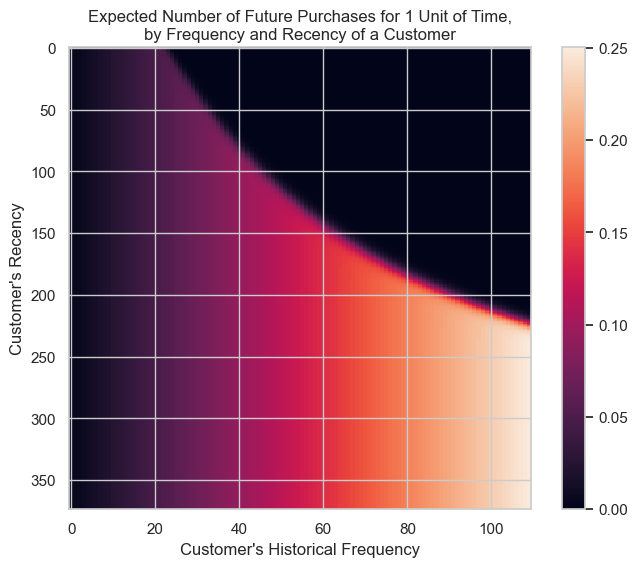

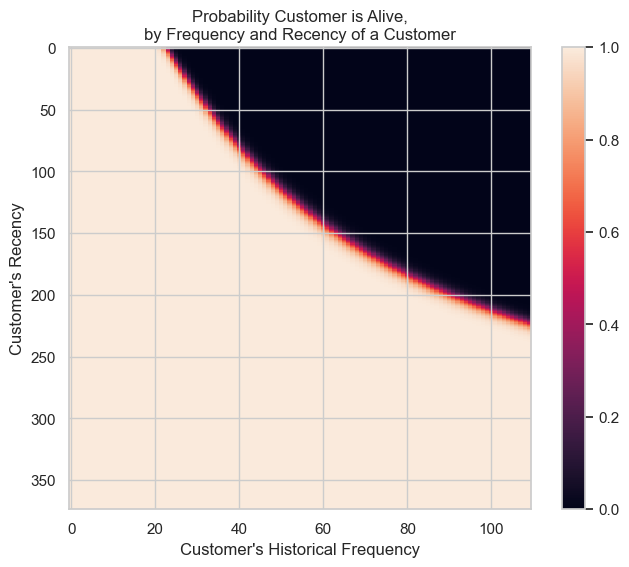

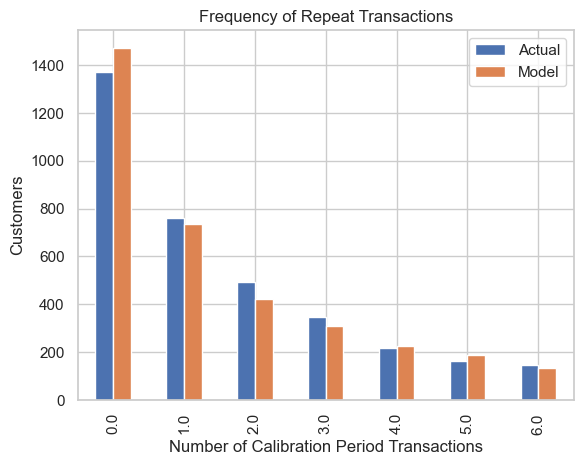

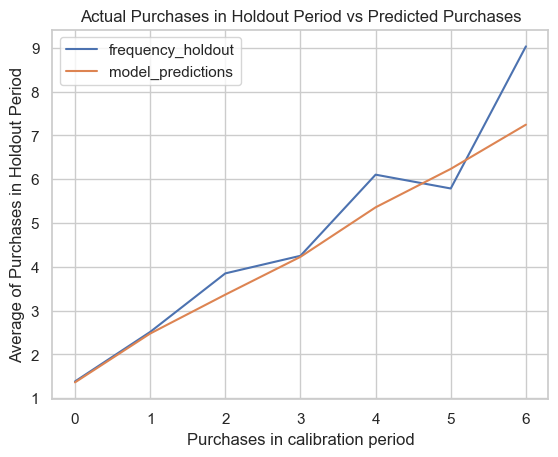

In [152]:

#Modified Beta Geom + Gamma Gamma Distribution Model

summary_mbg = summary.copy()
summary_mbg.head()

mbg = ModifiedBetaGeoFitter(penalizer_coef = 0.02)
mbg.fit(summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])

mbg.summary
plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(mbg)

plt.figure(figsize=(8,6))
plot_probability_alive_matrix(mbg)

t = 30
summary_mbg["predicted_purchases"] = mbg.conditional_expected_number_of_purchases_up_to_time(t, summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])

summary_mbg

plot_period_transactions(mbg)

#dividing our dataset into training & holdout
summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2010-05-08',
                                                  observation_period_end = '2010-12-09')
												  
												  
mbg.fit(summary_cal_holdout["frequency_cal"],
       summary_cal_holdout["recency_cal"],
       summary_cal_holdout["T_cal"])
	   
plot_calibration_purchases_vs_holdout_purchases(mbg, summary_cal_holdout)


In [153]:
from sklearn.metrics import mean_squared_error

Mean Squared Error: 1.7507363430780811
Average Error:  0.20482297260691745
Root Mean Squared Error: 1.3231539377858046


<Axes: >

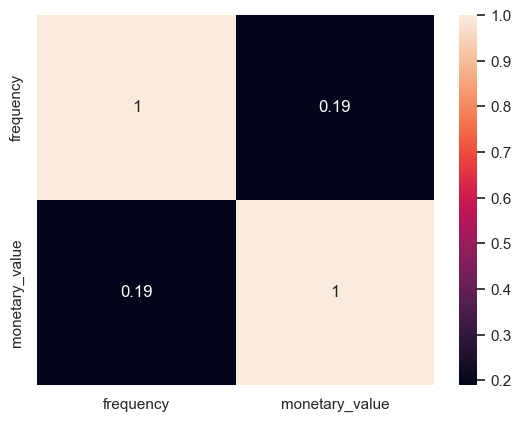

In [154]:

summary_mbg["actual_30"] = summary_mbg["frequency"]/summary_mbg["recency"]*30
summary_mbg = summary_mbg.fillna(value = 0)
summary_mbg.head()
summary_mbg["Error"] = summary_mbg["actual_30"] - summary_mbg["predicted_purchases"]


summary_mbg["p_not_alive"] = 1-mbg.conditional_probability_alive(summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])
summary_mbg["p_alive"] = mbg.conditional_probability_alive(summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])


mse = mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"])
print("Mean Squared Error: %s" % mse)
print("Average Error:  %s" % summary_mbg["Error"].mean())
print("Root Mean Squared Error: %s" % sqrt(mse))

mbg_mse_purchase = mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"])
mbg_rmse_purchase = sqrt(mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"]))
mbg_avg_purchase_error = (summary_mbg["actual_30"].mean() - summary_mbg["predicted_purchases"].mean())

res_summary = summary_mbg[summary_mbg["frequency"] > 0]
final_summary = res_summary[res_summary["monetary_value"] > 0]
sns.heatmap(final_summary[["frequency", "monetary_value"]].corr(), annot = True)

In [155]:
c=summary_mbg["Error"]
d=summary_mbg_new["monetary_value"]
e=summary_mbg_new["Expected_Avg_Sales"]

Expected Average Sales: 402.4657406103623
Actual Average Sales: 388.78968508393297
Difference: -13.676055526429309
Mean Squared Error: 15457.322615780782
Root Mean Squared Error: 124.32748133771867


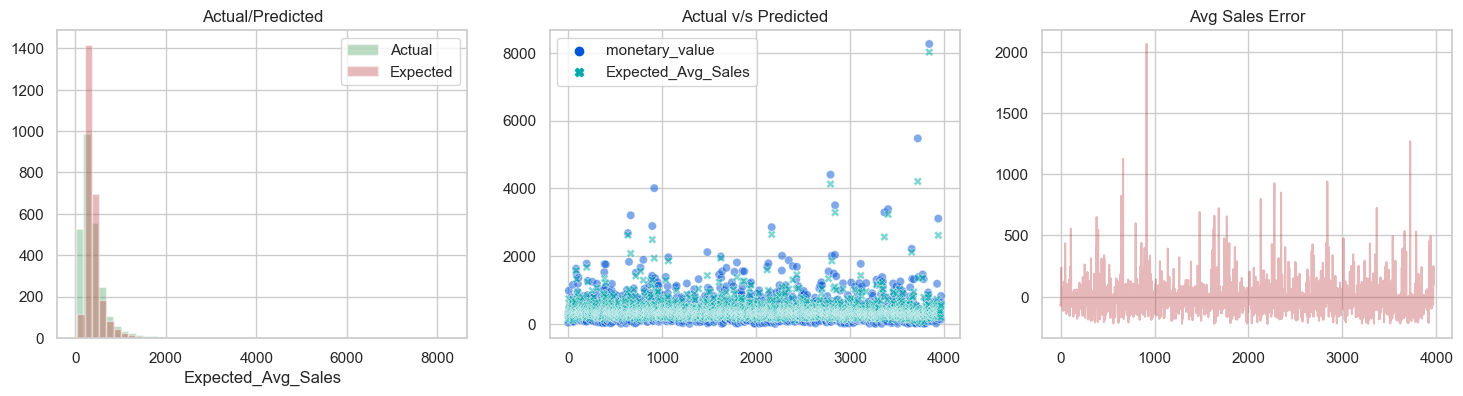

In [156]:

ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)
ggf.fit(final_summary["frequency"], final_summary["monetary_value"])
ggf.summary
summary_mbg_new = summary_mbg[(summary_mbg["monetary_value"] > 0) & (summary_mbg["frequency"] > 0)]
summary_mbg_new
summary_mbg_new["Expected_Avg_Sales"] = ggf.conditional_expected_average_profit(summary_mbg_new["frequency"], 
                                                                        summary_mbg_new["monetary_value"])

summary_mbg_new.head()
print("Expected Average Sales: %s" % summary_mbg_new["Expected_Avg_Sales"].mean())
print("Actual Average Sales: %s" % summary_mbg_new["monetary_value"].mean())
print("Difference: %s" % (summary_mbg_new["monetary_value"].mean() - summary_mbg_new["Expected_Avg_Sales"].mean()))
print("Mean Squared Error: %s" % mean_squared_error(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"])))

plt.figure(figsize=(18,4))
plt.subplot(131)
sns.distplot(summary_mbg_new["monetary_value"], color = "g", kde = False)
sns.distplot(summary_mbg_new["Expected_Avg_Sales"], color = "r", kde = False)
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])
plt.subplot(132)
#sns.scatterplot(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"], alpha = 0.5, hue = summary_mbg["Error"], palette = "winter")
sns.scatterplot(summary_mbg_new[["monetary_value","Expected_Avg_Sales"]], alpha = 0.5,  palette = "winter")
plt.title("Actual v/s Predicted")
plt.subplot(133)
plt.plot(summary_mbg_new["monetary_value"]-summary_mbg_new["Expected_Avg_Sales"], color = 'r', alpha = 0.4)
plt.title("Avg Sales Error")
plt.show()

<Axes: >

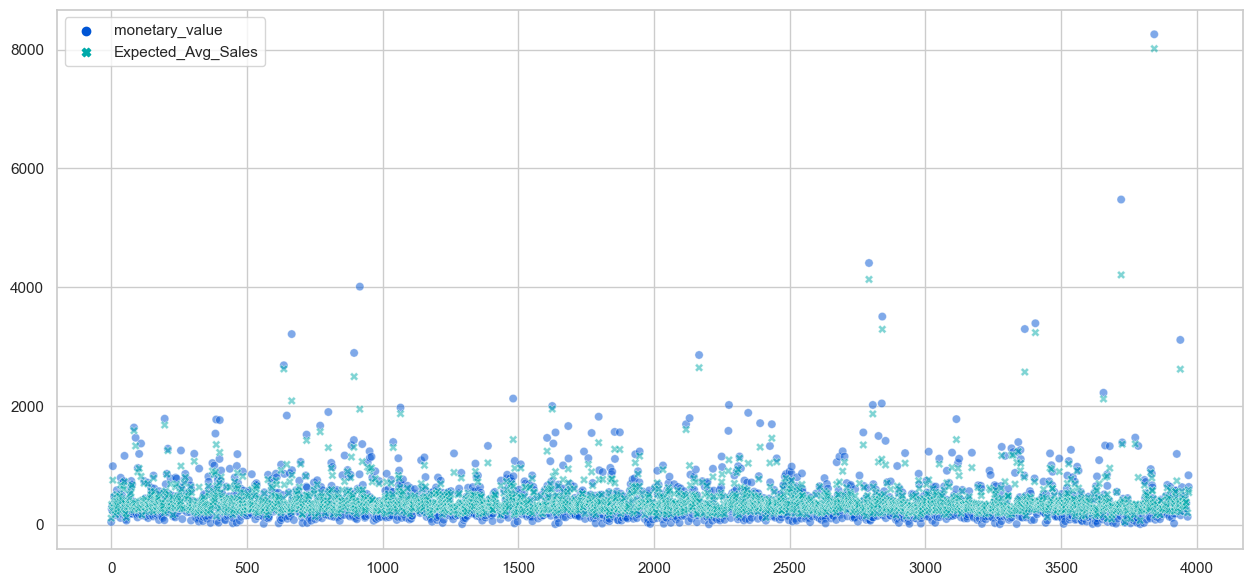

In [157]:
plt.figure(figsize=(52,7))
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])
plt.subplot(132)
#sns.scatterplot(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"], alpha = 0.5, hue = summary_mbg["Error"], palette = "winter")
sns.scatterplot(summary_mbg_new[["monetary_value","Expected_Avg_Sales"]], alpha = 0.5,  palette = "winter")

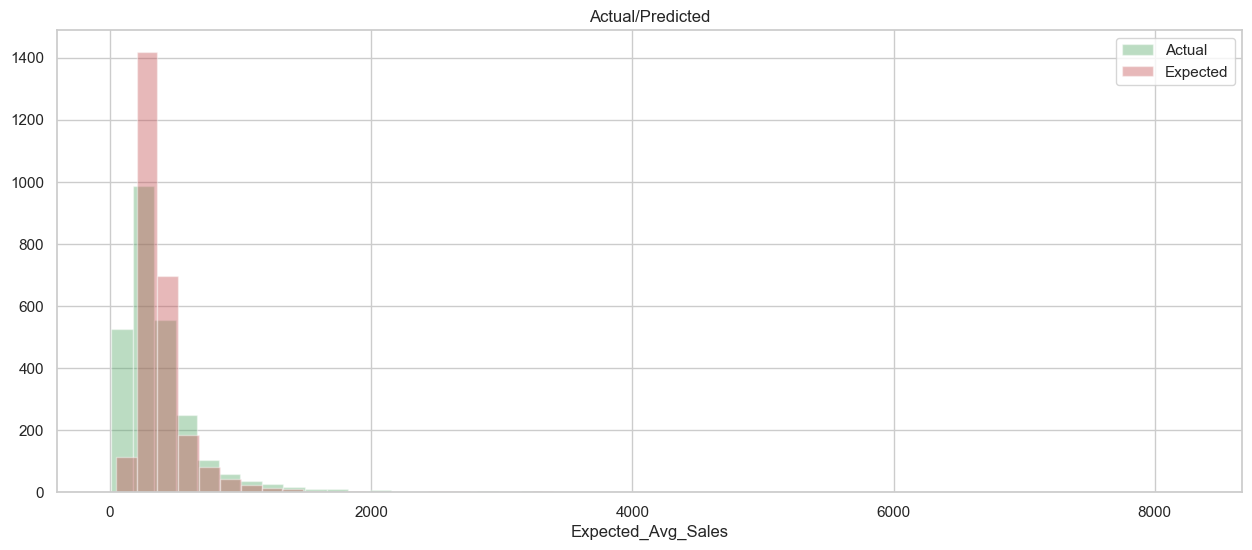

In [158]:
plt.figure(figsize=(52,6))
plt.subplot(131)
sns.distplot(summary_mbg_new["monetary_value"], color = "g", kde = False)
sns.distplot(summary_mbg_new["Expected_Avg_Sales"], color = "r", kde = False)
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])

In [159]:
summary_mbg_new[['monetary_value','Expected_Avg_Sales']]

,monetary_value,Expected_Avg_Sales
0,47.143333,111.008276
2,266.930000,342.105393
4,313.325333,320.276635
5,238.513263,240.726907
6,986.790000,751.530019
...,...,...
3960,275.652500,306.357767
3961,366.265000,379.159318
3966,135.105000,200.937287
3969,833.480000,584.964433


In [160]:
summary_mbg.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,p_not_alive,p_alive
0,12346.0,6.0,196.0,360.0,47.143333,0.479169,0.918367,0.439199,0.000000e+00,1.0
1,12608.0,0.0,0.0,39.0,0.000000,0.228311,0.000000,-0.228311,2.208449e-10,1.0
2,12745.0,1.0,88.0,209.0,266.930000,0.196193,0.340909,0.144716,0.000000e+00,1.0
3,12746.0,0.0,0.0,175.0,0.000000,0.099144,0.000000,-0.099144,4.174951e-10,1.0
4,12747.0,15.0,363.0,367.0,313.325333,1.095849,1.239669,0.143821,0.000000e+00,1.0


In [161]:
summary_mbg_new.isna().sum()

CustomerID             0
frequency              0
recency                0
T                      0
monetary_value         0
predicted_purchases    0
actual_30              0
Error                  0
p_not_alive            0
p_alive                0
Expected_Avg_Sales     0
dtype: int64

In [162]:
summary_mbg_new.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,p_not_alive,p_alive,Expected_Avg_Sales
0,12346.0,6.0,196.0,360.0,47.143333,0.479169,0.918367,0.439199,0.0,1.0,111.008276
2,12745.0,1.0,88.0,209.0,266.930000,0.196193,0.340909,0.144716,0.0,1.0,342.105393
4,12747.0,15.0,363.0,367.0,313.325333,1.095849,1.239669,0.143821,0.0,1.0,320.276635
5,12748.0,95.0,370.0,370.0,238.513263,6.600607,7.702703,1.102096,0.0,1.0,240.726907
6,12749.0,2.0,122.0,156.0,986.790000,0.378669,0.491803,0.113135,0.0,1.0,751.530019


In [163]:
#summary_mbg_new=summary_mbg_new.drop('CLV',axis=1)

In [164]:

summary_mbg_new["predicted_clv"] = ggf.customer_lifetime_value(mbg,
                                                       summary_mbg_new["frequency"],
                                                       summary_mbg_new["recency"],
                                                       summary_mbg_new["T"],
                                                       summary_mbg_new["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

summary_mbg_new

#summary_mbg_new["CLV"] = summary_mbg_new["predicted_clv"]*0.05

actual = summary_mbg_new["monetary_value"]*summary_mbg_new["actual_30"]
pred = summary_mbg_new["Expected_Avg_Sales"]*summary_mbg_new["predicted_purchases"]
error = actual - pred
result = pd.DataFrame([actual, pred, error], index = ["Actual", "Predicted", "Error"]).T

print("Average Error: %s" % result["Error"].mean())
print("Mean Squared Error: %s" % (mean_squared_error(result["Actual"], result["Predicted"])))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result["Actual"], result["Predicted"])))

Average Error: 115.2386949048559
Mean Squared Error: 254210.3508154357
Root Mean Squared Error: 504.1927714827293


In [165]:
summary_mbg_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2598 entries, 0 to 3970
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2598 non-null   float64
 1   frequency            2598 non-null   float64
 2   recency              2598 non-null   float64
 3   T                    2598 non-null   float64
 4   monetary_value       2598 non-null   float64
 5   predicted_purchases  2598 non-null   float64
 6   actual_30            2598 non-null   float64
 7   Error                2598 non-null   float64
 8   p_not_alive          2598 non-null   float64
 9   p_alive              2598 non-null   float64
 10  Expected_Avg_Sales   2598 non-null   float64
 11  predicted_clv        2598 non-null   float64
dtypes: float64(12)
memory usage: 328.4 KB


In [166]:
summary_mbg_new.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,p_not_alive,p_alive,Expected_Avg_Sales,predicted_clv
0,12346.0,6.0,196.0,360.0,47.143333,0.479169,0.918367,0.439199,0.0,1.0,111.008276,1390.448933
2,12745.0,1.0,88.0,209.0,266.930000,0.196193,0.340909,0.144716,0.0,1.0,342.105393,1717.623313
4,12747.0,15.0,363.0,367.0,313.325333,1.095849,1.239669,0.143821,0.0,1.0,320.276635,9236.027372
5,12748.0,95.0,370.0,370.0,238.513263,6.600607,7.702703,1.102096,0.0,1.0,240.726907,41992.512150
6,12749.0,2.0,122.0,156.0,986.790000,0.378669,0.491803,0.113135,0.0,1.0,751.530019,7482.166344


In [167]:
ggf_filter=summary_mbg_new

In [168]:
summary_mbg_new.to_csv('CLV_data_from_MBG.csv')

In [169]:
#del ggf_filter

In [170]:
# CUSTOMER SEGMENTATION USING PREDICTED CLV

In [171]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,p_not_alive,p_alive,Expected_Avg_Sales,predicted_clv
0,12346.0,6.0,196.0,360.0,47.143333,0.479169,0.918367,0.439199,0.0,1.0,111.008276,1390.448933
2,12745.0,1.0,88.0,209.0,266.930000,0.196193,0.340909,0.144716,0.0,1.0,342.105393,1717.623313
4,12747.0,15.0,363.0,367.0,313.325333,1.095849,1.239669,0.143821,0.0,1.0,320.276635,9236.027372
5,12748.0,95.0,370.0,370.0,238.513263,6.600607,7.702703,1.102096,0.0,1.0,240.726907,41992.512150
6,12749.0,2.0,122.0,156.0,986.790000,0.378669,0.491803,0.113135,0.0,1.0,751.530019,7482.166344


In [172]:
ggf_filter["profit_margin"] = ggf_filter["predicted_clv"]*0.05

In [173]:
#col = ["predicted_purchases", "expected_avg_sales_", "predicted_clv", "profit_margin"]
col = ["predicted_purchases", "Expected_Avg_Sales", "predicted_clv", "profit_margin"]

In [174]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,p_not_alive,p_alive,Expected_Avg_Sales,predicted_clv,profit_margin
0,12346.0,6.0,196.0,360.0,47.143333,0.479169,0.918367,0.439199,0.0,1.0,111.008276,1390.448933,69.522447
2,12745.0,1.0,88.0,209.0,266.930000,0.196193,0.340909,0.144716,0.0,1.0,342.105393,1717.623313,85.881166
4,12747.0,15.0,363.0,367.0,313.325333,1.095849,1.239669,0.143821,0.0,1.0,320.276635,9236.027372,461.801369
5,12748.0,95.0,370.0,370.0,238.513263,6.600607,7.702703,1.102096,0.0,1.0,240.726907,41992.512150,2099.625608
6,12749.0,2.0,122.0,156.0,986.790000,0.378669,0.491803,0.113135,0.0,1.0,751.530019,7482.166344,374.108317


In [175]:
ggf_filter.isna().sum()

CustomerID             0
frequency              0
recency                0
T                      0
monetary_value         0
predicted_purchases    0
actual_30              0
Error                  0
p_not_alive            0
p_alive                0
Expected_Avg_Sales     0
predicted_clv          0
profit_margin          0
dtype: int64

In [176]:
#ggf_filter=ggf_filter.drop('Labels',axis=1)

In [177]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

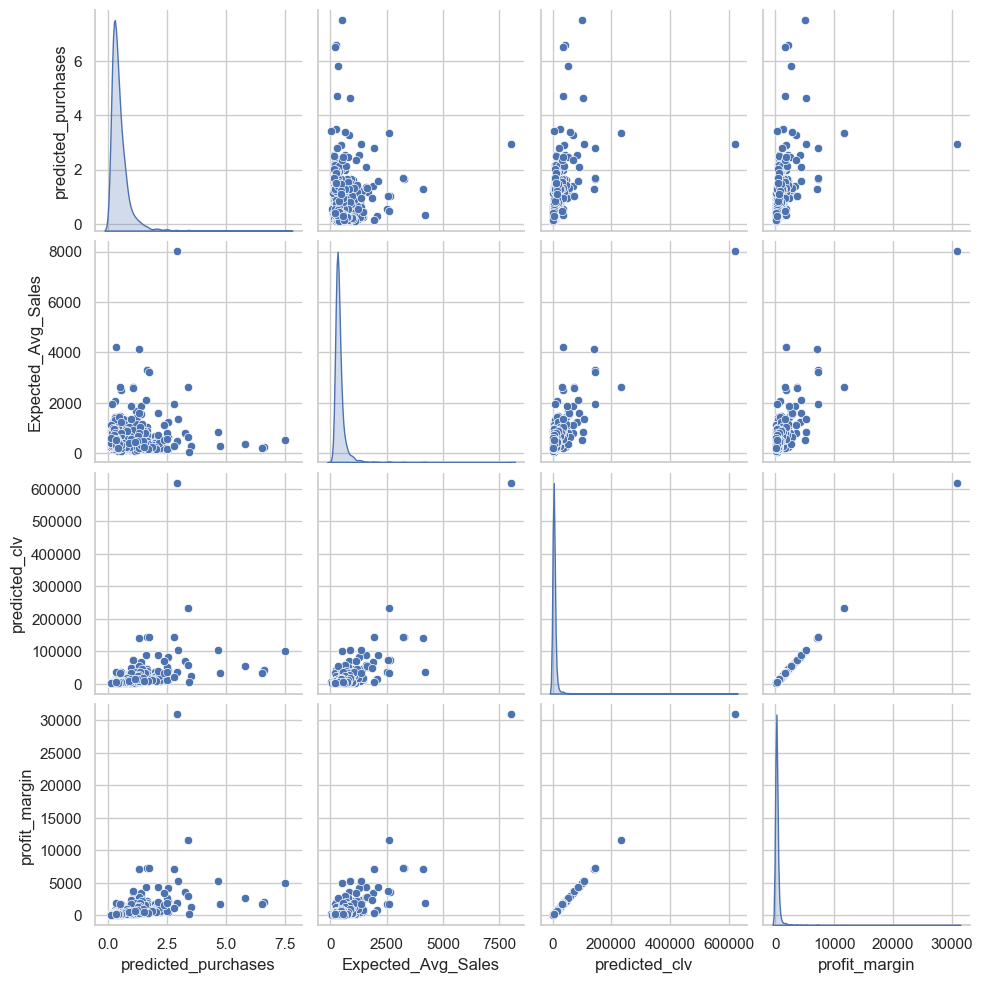

In [178]:
sns.pairplot(ggf_filter[col], diag_kind = "kde")

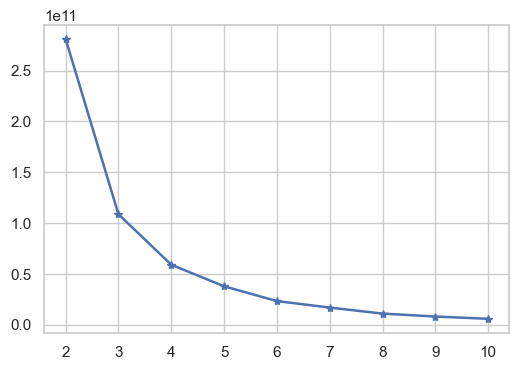

In [179]:
new_df = ggf_filter[col]
from sklearn.cluster import KMeans

inertia = []

for i in range(2, 11):
    cluster = KMeans(n_clusters = i, init = "k-means++").fit(new_df)
    inertia.append(cluster.inertia_)
    
plt.figure(figsize=(6,4))
plt.plot(range(2,11), inertia, marker = "*", linewidth = 1.8)

In [180]:
k_model = KMeans(n_clusters = 4, init = "k-means++", max_iter = 1000)

In [181]:
k_model_fit = k_model.fit(new_df)

In [182]:
new_df

,predicted_purchases,Expected_Avg_Sales,predicted_clv,profit_margin
0,0.479169,111.008276,1390.448933,69.522447
2,0.196193,342.105393,1717.623313,85.881166
4,1.095849,320.276635,9236.027372,461.801369
5,6.600607,240.726907,41992.512150,2099.625608
6,0.378669,751.530019,7482.166344,374.108317
...,...,...,...,...
3960,0.334972,306.357767,2667.951814,133.397591
3961,0.431265,379.159318,4329.403203,216.470160
3966,0.401332,200.937287,2107.108196,105.355410
3969,0.127148,584.964433,1876.861501,93.843075


In [183]:
centers = k_model_fit.cluster_centers_

In [184]:
centers

array([[4.29894119e-01, 3.75880737e+02, 4.14831112e+03, 2.07415556e+02],
       [2.92852349e+00, 8.01722891e+03, 6.19714083e+05, 3.09857041e+04],
       [2.92049878e+00, 2.08142818e+03, 1.25177117e+05, 6.25885585e+03],
       [1.78228046e+00, 1.00331411e+03, 3.50954951e+04, 1.75477475e+03]])

In [185]:
labels = k_model_fit.labels_
labels = pd.Series(labels, name = "Labels")

In [186]:
labels

0       0
1       0
2       0
3       3
4       0
       ..
2593    0
2594    0
2595    0
2596    0
2597    0
Name: Labels, Length: 2598, dtype: int32

In [187]:
ggf_filter = pd.concat([ggf_filter, labels], axis = 1)

In [188]:
ggf_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3488 entries, 0 to 2596
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2598 non-null   float64
 1   frequency            2598 non-null   float64
 2   recency              2598 non-null   float64
 3   T                    2598 non-null   float64
 4   monetary_value       2598 non-null   float64
 5   predicted_purchases  2598 non-null   float64
 6   actual_30            2598 non-null   float64
 7   Error                2598 non-null   float64
 8   p_not_alive          2598 non-null   float64
 9   p_alive              2598 non-null   float64
 10  Expected_Avg_Sales   2598 non-null   float64
 11  predicted_clv        2598 non-null   float64
 12  profit_margin        2598 non-null   float64
 13  Labels               2598 non-null   float64
dtypes: float64(14)
memory usage: 408.8 KB


In [189]:
ggf_filter.drop('CustomerID', axis = 1).groupby('Labels').median()

,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,p_not_alive,p_alive,Expected_Avg_Sales,predicted_clv,profit_margin
Labels,,,,,,,,,,,,
0.0,3.0,217.0,290.0,313.076000,0.360355,0.502793,0.097611,0.0,1.0,351.201623,3308.514519,165.425726
1.0,1.0,34.0,219.0,476.360000,0.189294,0.882353,0.693059,0.0,1.0,431.880292,2089.164820,104.458241
2.0,3.5,233.0,332.0,336.933750,0.389479,0.802443,0.141819,0.0,1.0,366.826290,3029.712122,151.485606
3.0,3.0,245.0,298.0,311.438611,0.443689,0.583693,0.100872,0.0,1.0,330.130238,4202.620320,210.131016


In [190]:
ggf_filter.drop('CustomerID', axis = 1).groupby('Labels').mean()

,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,p_not_alive,p_alive,Expected_Avg_Sales,predicted_clv,profit_margin
Labels,,,,,,,,,,,,
0.0,4.489413,207.84634,266.120992,394.718611,0.473457,0.824303,0.350846,0.0,1.0,403.548902,5424.655519,271.232776
1.0,1.000000,34.00000,219.000000,476.360000,0.189294,0.882353,0.693059,0.0,1.0,431.880292,2089.164820,104.458241
2.0,4.125000,213.75000,275.375000,295.122574,0.434870,0.955889,0.521019,0.0,1.0,324.693168,3898.369059,194.918453
3.0,5.804348,233.26087,273.108696,426.928608,0.556995,0.820971,0.263976,0.0,1.0,434.001252,7466.820281,373.341014


In [191]:
ggf_filter.Labels.unique()

array([ 0.,  2.,  3.,  1., nan])

In [192]:
descriptive_stats_by_label = ggf_filter.groupby('Labels').agg(['mean', 'median', 'min', 'max', 'std']).T

# Display the descriptive statistics for each label
descriptive_stats_by_label

Labels                         0.0           1.0           2.0           3.0
CustomerID    mean    14617.650333  16317.000000  14839.375000  14610.934783
              median  14599.000000  16317.000000  14912.000000  14730.500000
              min     12346.000000  16317.000000  12880.000000  12931.000000
              max     16409.000000  16317.000000  16223.000000  16283.000000
              std      1041.749939           NaN   1282.315421   1067.156479
...                            ...           ...           ...           ...
profit_margin mean      271.232776    104.458241    194.918453    373.341014
              median    165.425726    104.458241    151.485606    210.131016
              min        35.937520    104.458241     61.092020     46.891995
              max     11647.384283    104.458241    370.165773   4404.728876
              std       496.950344           NaN    122.052352    653.541278

[65 rows x 4 columns]

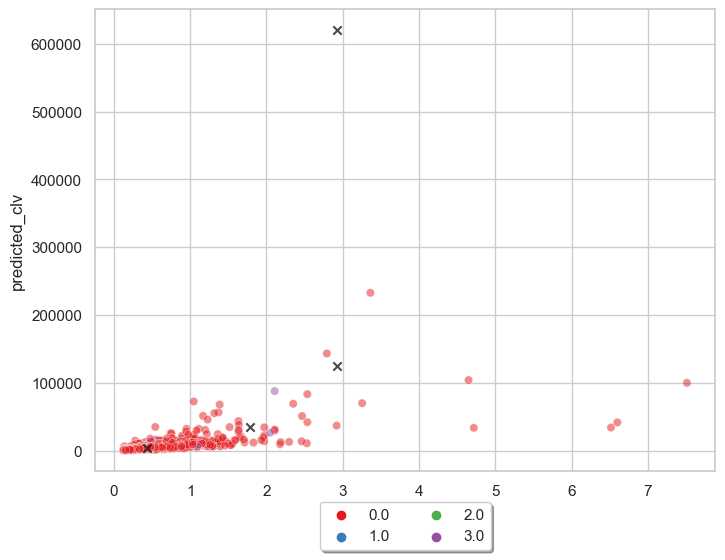

In [193]:
plt.figure(figsize=(8,6))
sns.scatterplot(x = "predicted_purchases", y = "predicted_clv", hue = "Labels", palette = "Set1", data = ggf_filter, alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 2], marker = "x", color = "k", alpha = 0.8)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)

In [194]:
#plt.figure(figsize=(5,5))
#plt.pie(ggf_filter["Labels"].value_counts(), labels = ggf_filter["Labels"].unique(), startangle = 180, explode = [0.0,1.5,1.5,0.0], autopct = "%1.2f%%")
#plt.title("Label Percentage")
#plt.legend()

In [195]:
cx=labels=[0,1,2,3]

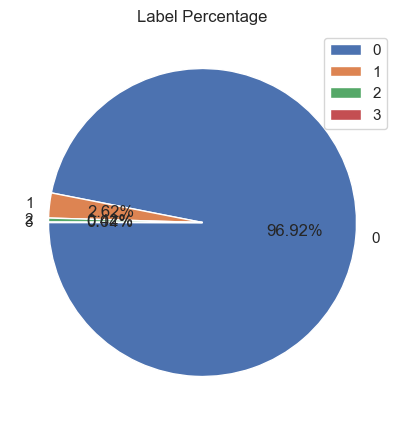

In [196]:
plt.figure(figsize=(5,5))
plt.pie(ggf_filter["Labels"].value_counts(), labels = cx, startangle = 180, explode = None, autopct = "%1.2f%%")
plt.title("Label Percentage")
plt.legend()
plt.show()

In [197]:
ggf_filter["Labels"].unique()


array([ 0.,  2.,  3.,  1., nan])

In [198]:
ggf_filter.isna().sum()

CustomerID             890
frequency              890
recency                890
T                      890
monetary_value         890
predicted_purchases    890
actual_30              890
Error                  890
p_not_alive            890
p_alive                890
Expected_Avg_Sales     890
predicted_clv          890
profit_margin          890
Labels                 890
dtype: int64

In [199]:
ggf_filter.shape

(3488, 14)

In [200]:
ggf_filter.CustomerID.isna().sum()

890

In [201]:
ggf_filter = ggf_filter[pd.notnull(ggf_filter['CustomerID'])]

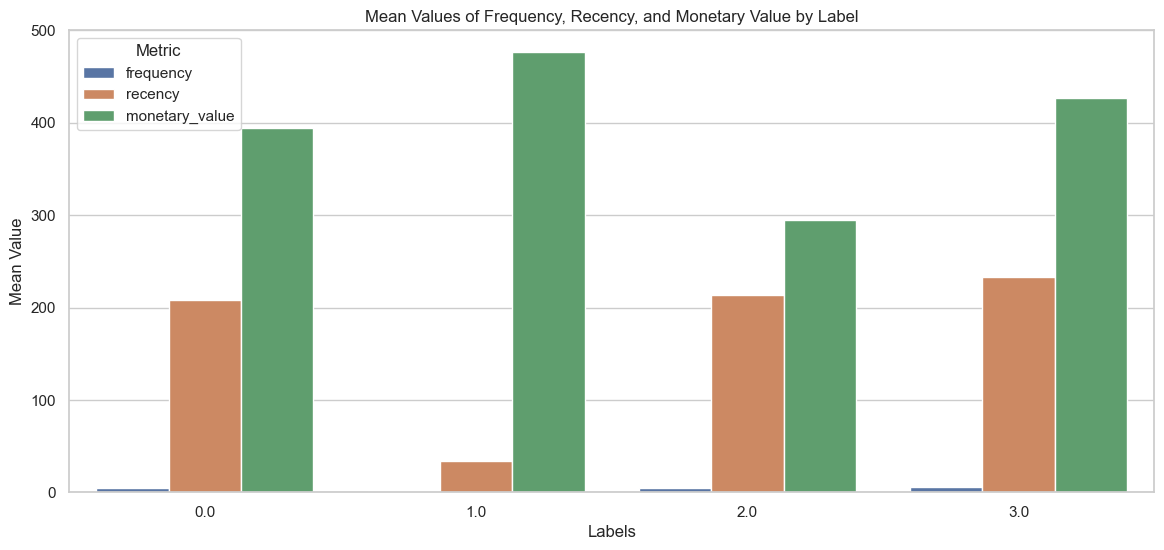

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Create a new DataFrame for the mean values of key metrics
df_means = ggf_filter.groupby('Labels')[['frequency', 'recency', 'monetary_value']].mean().reset_index()

# Create a bar plot for the mean values of frequency, recency, and monetary value for each label
plt.figure(figsize=(14, 6))
sns.barplot(x='Labels', y='value', hue='variable', data=pd.melt(df_means, id_vars='Labels'))
plt.title('Mean Values of Frequency, Recency, and Monetary Value by Label')
plt.ylabel('Mean Value')
plt.xlabel('Labels')
plt.legend(title='Metric')
plt.show()

## Here's a summary of the customer characteristics for each label. This will help us to understand the types of customers represented by each label

## *Label 2:* These customers have a low average frequency of purchases and their recent activity varies widely. They have the lowest average monetary value among all labels, indicating they may be occasional shoppers or new customers.

## *Label 1:* This label represents a unique group with a high frequency of purchases and the highest monetary value, suggesting these are premium customers, possibly bulk buyers or loyal customers with high engagement.

## *Label 3:* Customers in this label also show a high frequency of purchases and a high monetary value, but with a slightly lower average than Label 1. They could be considered as regular customers with significant spending.

## *Label 0:* BEST ONE TO TARGET These customers have a moderate frequency of purchases and their recent activity is quite high. Their monetary value is lower than Labels 1 and 3, which might indicate they are regular but not high-spending customers.

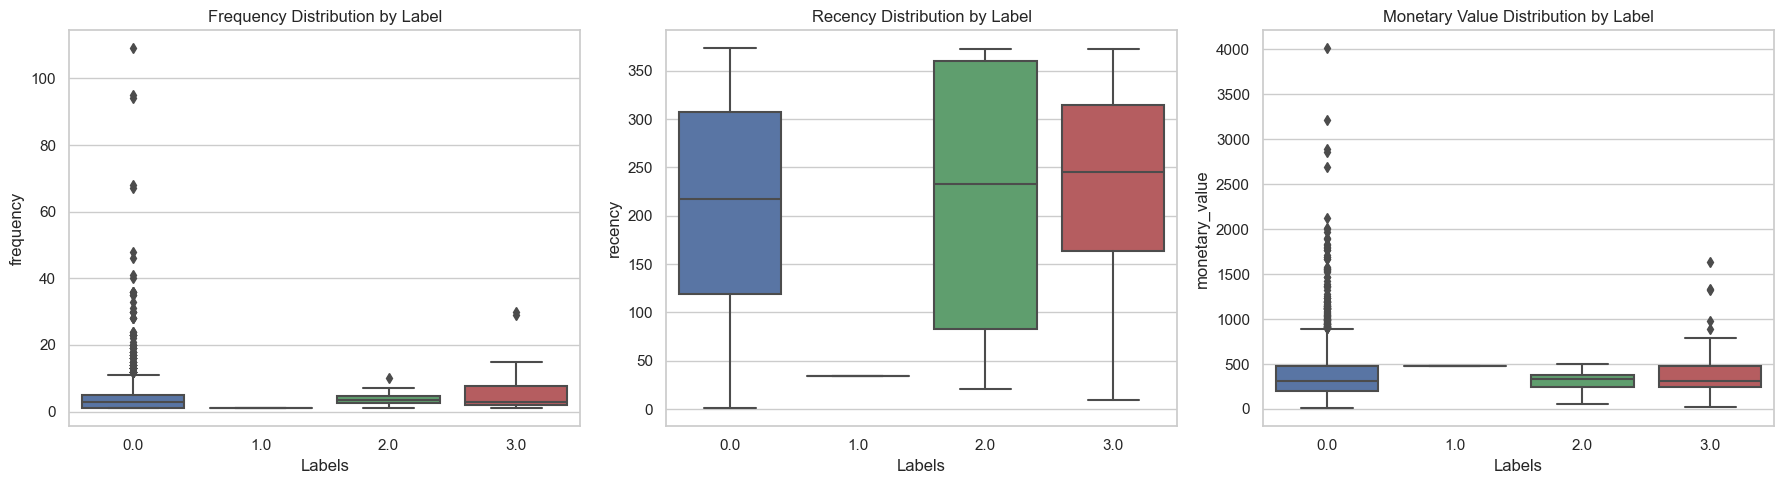

In [204]:
# Create box plots for the distribution of frequency, recency, and monetary value for each label
plt.figure(figsize=(18, 5))

# Frequency
plt.subplot(1, 3, 1)
sns.boxplot(x='Labels', y='frequency', data=ggf_filter)
plt.title('Frequency Distribution by Label')

# Recency
plt.subplot(1, 3, 2)
sns.boxplot(x='Labels', y='recency', data=ggf_filter)
plt.title('Recency Distribution by Label')

# Monetary Value
plt.subplot(1, 3, 3)
sns.boxplot(x='Labels', y='monetary_value', data=ggf_filter)
plt.title('Monetary Value Distribution by Label')

plt.tight_layout()
plt.show()

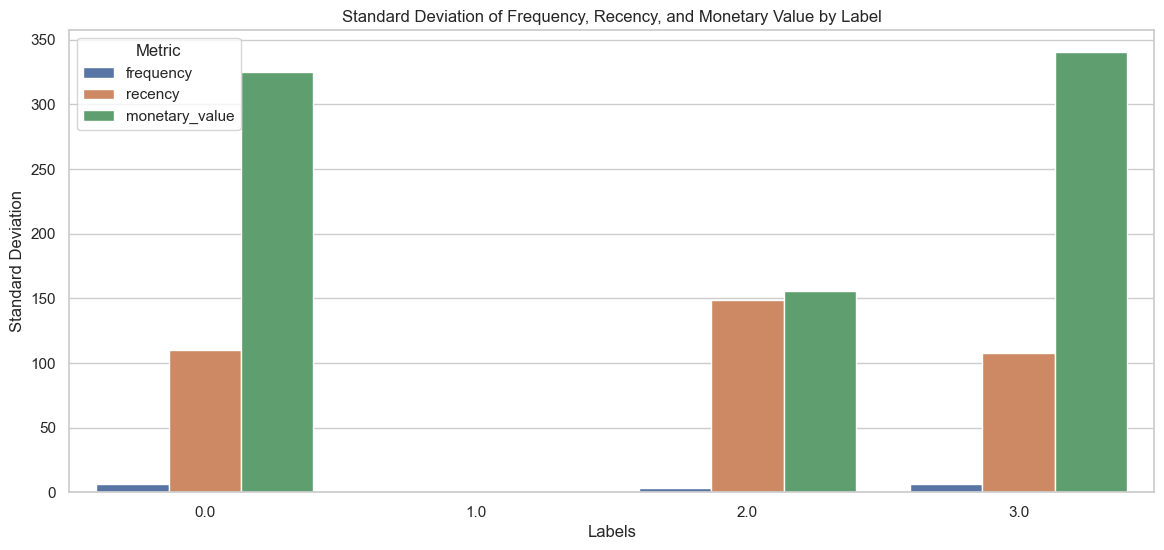

In [205]:
# Create a DataFrame for the standard deviation of key metrics
df_std = ggf_filter.groupby('Labels')[['frequency', 'recency', 'monetary_value']].std().reset_index()

# Create a bar plot for the standard deviation of frequency, recency, and monetary value for each label
plt.figure(figsize=(14, 6))
sns.barplot(x='Labels', y='value', hue='variable', data=pd.melt(df_std, id_vars='Labels'))
plt.title('Standard Deviation of Frequency, Recency, and Monetary Value by Label')
plt.ylabel('Standard Deviation')
plt.xlabel('Labels')
plt.legend(title='Metric')
plt.show()

In [206]:
#ggf_filter.to_csv('output_after_Kmeans.csv')

In [207]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,p_not_alive,p_alive,Expected_Avg_Sales,predicted_clv,profit_margin,Labels
0,12346.0,6.0,196.0,360.0,47.143333,0.479169,0.918367,0.439199,0.0,1.0,111.008276,1390.448933,69.522447,0.0
2,12745.0,1.0,88.0,209.0,266.930000,0.196193,0.340909,0.144716,0.0,1.0,342.105393,1717.623313,85.881166,0.0
4,12747.0,15.0,363.0,367.0,313.325333,1.095849,1.239669,0.143821,0.0,1.0,320.276635,9236.027372,461.801369,0.0
5,12748.0,95.0,370.0,370.0,238.513263,6.600607,7.702703,1.102096,0.0,1.0,240.726907,41992.512150,2099.625608,0.0
6,12749.0,2.0,122.0,156.0,986.790000,0.378669,0.491803,0.113135,0.0,1.0,751.530019,7482.166344,374.108317,0.0


In [208]:
ggf_filter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2598 entries, 0 to 3970
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2598 non-null   float64
 1   frequency            2598 non-null   float64
 2   recency              2598 non-null   float64
 3   T                    2598 non-null   float64
 4   monetary_value       2598 non-null   float64
 5   predicted_purchases  2598 non-null   float64
 6   actual_30            2598 non-null   float64
 7   Error                2598 non-null   float64
 8   p_not_alive          2598 non-null   float64
 9   p_alive              2598 non-null   float64
 10  Expected_Avg_Sales   2598 non-null   float64
 11  predicted_clv        2598 non-null   float64
 12  profit_margin        2598 non-null   float64
 13  Labels               1708 non-null   float64
dtypes: float64(14)
memory usage: 304.5 KB


In [209]:
ggf_filter.rename(columns={'Labels': 'Lables_MBG_KMeans'}, inplace=True)

In [210]:
output_after_Kmeans = ggf_filter.drop('frequency', axis=1)

In [211]:
output_after_Kmeans = output_after_Kmeans.drop('recency', axis=1)

In [212]:
output_after_Kmeans = output_after_Kmeans.drop('T', axis=1)

In [213]:
output_after_Kmeans = output_after_Kmeans.drop('monetary_value', axis=1)

In [214]:
output_after_Kmeans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2598 entries, 0 to 3970
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2598 non-null   float64
 1   predicted_purchases  2598 non-null   float64
 2   actual_30            2598 non-null   float64
 3   Error                2598 non-null   float64
 4   p_not_alive          2598 non-null   float64
 5   p_alive              2598 non-null   float64
 6   Expected_Avg_Sales   2598 non-null   float64
 7   predicted_clv        2598 non-null   float64
 8   profit_margin        2598 non-null   float64
 9   Lables_MBG_KMeans    1708 non-null   float64
dtypes: float64(10)
memory usage: 223.3 KB


In [215]:
ggf_filter.to_csv('output_after_Kmeans.csv')